In [1]:
import os
import cv2
import pandas as pd
import seaborn as sns
import numpy as np
import shutil
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#df_train = pd.read_csv(r"/content/drive/My Drive/Cleaned_Features.csv")
#df_test = pd.read_csv(r"/content/drive/My Drive/Cleaned_test_Features.csv")
#df_train = pd.DataFrame(df_train)
#df_test = pd.DataFrame(df_test)


In [3]:
df_train = pd.read_excel(r"/content/drive/My Drive/extracted feature sheets/Extracted_Features_train.xlsx")
df_test = pd.read_excel(r"/content/drive/My Drive/extracted feature sheets/Extracted_Features_test.xlsx")
df_train = pd.DataFrame(df_train)
df_test = pd.DataFrame(df_test)

In [4]:
df_train.head()


,Contrast,Energy,Homogeneity,Correlation,Dissimilarity,ASM,Entropy,Subtype,Image_Name,Shannon_Entropy,Fractal_Dimension
0,261.082742,0.014654,0.103927,0.883135,11.829791,0.000215,12.879239,Endometri,image_edo_0_3097.jpg,14.092138,1.878816
1,129.206502,0.024291,0.164012,0.906699,7.995975,0.000590,11.845309,Endometri,image_edo_0_2178.jpg,12.235772,1.852947
2,438.755216,0.036208,0.133857,0.917064,14.955695,0.001311,13.269874,Endometri,endo10.JPG,14.445177,1.833993
3,256.390103,0.014135,0.103701,0.883036,11.885496,0.000200,12.889959,Endometri,image_edo_0_2609.jpg,14.905214,1.853954
4,562.744602,0.010545,0.064645,0.808104,17.658940,0.000111,13.652711,Endometri,endo12.JPG,15.454333,1.869099


In [5]:
df_test.head()

,Contrast,Energy,Homogeneity,Correlation,Dissimilarity,ASM,Entropy,Subtype,Image_Name,Shannon_Entropy,Fractal_Dimension
0,354.541780,0.026833,0.141597,0.944028,12.687206,0.000720,12.872647,Endometri,endo8JPG.JPG,14.143645,1.742202
1,390.911519,0.012396,0.076806,0.836806,14.815680,0.000154,13.244677,Endometri,endo.JP7G.JPG,14.822747,1.882493
2,294.899323,0.014214,0.095067,0.839500,12.704437,0.000202,12.824422,Endometri,end3.JPG,14.302134,1.869746
3,115.927725,0.018204,0.143183,0.927751,7.929327,0.000331,12.097494,Endometri,image_edo_0_1756.jpg,14.272883,1.836745
4,64.924437,0.073520,0.287086,0.923036,5.249821,0.005405,10.140345,Endometri,image_edo_0_2234.jpg,10.007195,1.874242


In [6]:
# Create a new dataframe with only required features
df_train_input = df_train[[
    'Contrast', 'Energy', 'Homogeneity',
    'Correlation', 'Dissimilarity', 'Entropy',
    'Shannon_Entropy', 'Fractal_Dimension',
    'Subtype'
]]

print(f"Number of rows in training dataset: {df_train_input.shape[0]}")

df_test_input = df_test[[
    'Contrast', 'Energy', 'Homogeneity',
    'Correlation', 'Dissimilarity', 'Entropy',
    'Shannon_Entropy', 'Fractal_Dimension',
    'Subtype'
]]

print(f"Number of rows in testing dataset: {df_test_input.shape[0]}")

Number of rows in training dataset: 1999
Number of rows in testing dataset: 500



XGBoost Classification Report on Test Data:
               precision    recall  f1-score   support

   Clear_Cell       0.65      0.74      0.69       100
    Endometri       0.81      0.88      0.85       100
     Mucinous       0.65      0.68      0.66       100
Non_Cancerous       0.77      0.70      0.73       100
       Serous       0.84      0.70      0.77       100

     accuracy                           0.74       500
    macro avg       0.75      0.74      0.74       500
 weighted avg       0.75      0.74      0.74       500

XGBoost Model Accuracy on Test Data: 0.74


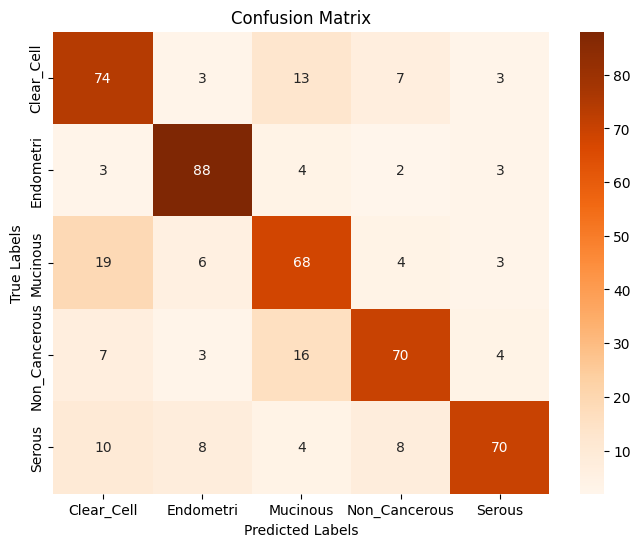

In [7]:
# Prepare features and labels for training data
X_train = df_train_input.drop(columns=['Subtype'])
X_test = df_test_input.drop(columns=['Subtype'])

# Encode categorical labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train_input['Subtype'])
y_test = label_encoder.transform(df_test_input['Subtype'])  # Encode test labels correctly

# Initialize and Train XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=20, random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Decode predictions back to original labels
y_test_decoded = label_encoder.inverse_transform(y_test)  #
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Classification Report
print("\nXGBoost Classification Report on Test Data:")
print(classification_report(y_test_decoded, y_pred_decoded))

# Accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"XGBoost Model Accuracy on Test Data: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Fine Tunning

In [8]:
param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [3, 6, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}


In [ ]:
xgb = XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_), random_state=42, use_label_encoder=False, eval_metric='mlogloss')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=100,
    scoring='accuracy',
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [10]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

print("\nFine-Tuned XGBoost Classification Report:")
print(classification_report(y_test_decoded, y_pred_decoded))

accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Fine-Tuned XGBoost Model Accuracy: {accuracy:.2f}")



Fine-Tuned XGBoost Classification Report:
               precision    recall  f1-score   support

   Clear_Cell       0.66      0.76      0.71       100
    Endometri       0.82      0.89      0.85       100
     Mucinous       0.64      0.69      0.67       100
Non_Cancerous       0.72      0.70      0.71       100
       Serous       0.86      0.62      0.72       100

     accuracy                           0.73       500
    macro avg       0.74      0.73      0.73       500
 weighted avg       0.74      0.73      0.73       500

Fine-Tuned XGBoost Model Accuracy: 0.73


In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
